# Exploration - Machine Temperature Dataset 

In this notebook, we conduct an exploratory analysis of the machine temperature dataset from the NAB (Numenta Anomaly Benchmark). The objective is to gain initial insights into the dataset structure and visualize patterns.

Goals:
- Load the NAB machine temperature series + labeled anomaly windows
- Quick EDA: ranges, missing values, sampling interval
- Visualize full series with shaded anomaly windows

## 1: Setup

Import core libraries and helper functions from our "utils" module.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pathlib

repo_root = pathlib.Path.cwd().resolve().parents[1]  
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# utils from this repo
from utils.data_loader import load_dataset  # if you added DATASETS registry
# fallback if you didn’t add the registry yet:
# from utils.data_loader import load_data_and_labels

from utils.visualizations import (
    plot_full_series_with_windows,
    plot_series_with_windows_and_points,
    plot_error_and_threshold,
)



## 2: Load the Machine Temperature Dataset



In [31]:
df, anomaly_windows = load_dataset("machine_temperature")
df.head()


,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


## 3: Dataset Overview

Check the shape, time range, column names, and missing values.  


In [32]:
print("Shape:", df.shape)
print("Time range:", df.index.min(), "→", df.index.max())
print("Columns:", list(df.columns))

print("\n.describe():")
display(df.describe())


print("\nMissing values by column:\n", df.isna().sum())

print("\nIntervals:")
print(df.index.to_series().diff().value_counts().head())

Shape: (22695, 1)
Time range: 2013-12-02 21:15:00 → 2014-02-19 15:25:00
Columns: ['value']

.describe():


,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543



Missing values by column:
 value    0
dtype: int64

Intervals:
timestamp
0 days 00:05:00    22682
0 days 00:00:00       12
Name: count, dtype: int64


This dataset contains 22,695 observations of a single variable (`value`) representing machine temperature.  
The time span covers December 2, 2013 through February 19, 2014, with measurements recorded at a fixed 5-minute interval.  

There are no missing values, which makes the series clean for modeling and avoids the need for imputation.  
Because the timestamps are evenly spaced, the data is well-suited for both statistical anomaly detectors and time-series forecasting methods.  


## 4: Plot Full Series with Labeled Anomalies

Plot the machine temperature and overlay NAB anomaly windows as shaded regions.


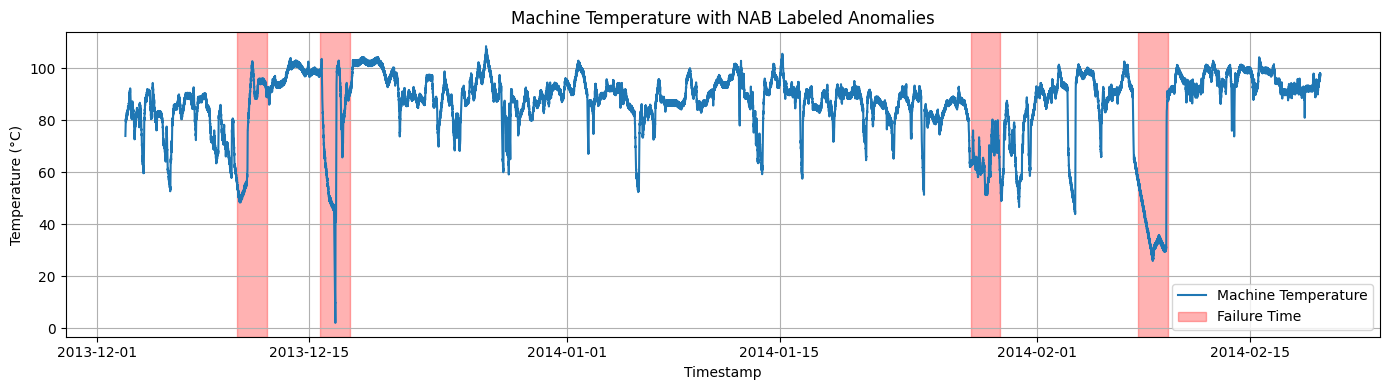

In [33]:
plot_full_series_with_windows(
    df,
    value_col="value",
    windows=anomaly_windows,
    title="Machine Temperature with NAB Labeled Anomalies",
    series_label="Machine Temperature",
    ylabel="Temperature (°C)",
)


- Shaded regions mark NAB’s failure windows. Visually, anomalies tend to coincide with sudden temperature drops followed by sustained low levels.
- Outside windows, behavior is fairly stable with short dips but no clear diurnal pattern.

## 5: Distribution of Values

We plot a histogram to see the distribution of machine temperature values.


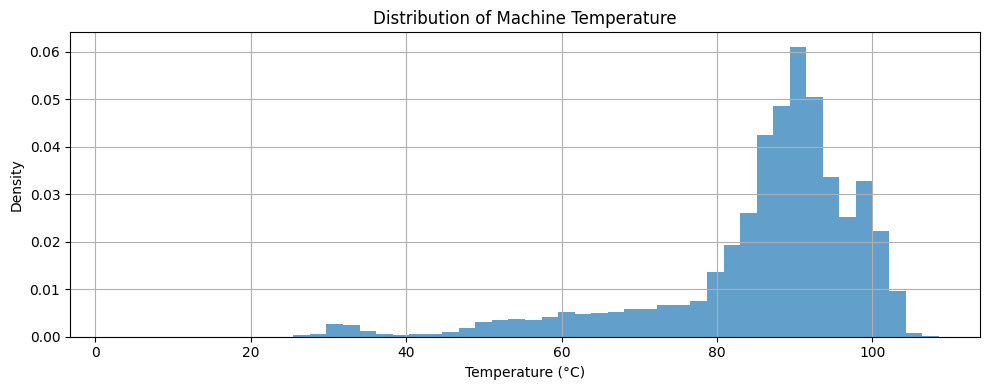

In [34]:
plt.figure(figsize=(10,4))
plt.hist(df["value"].dropna(), bins=50, alpha=0.7, density=True)
plt.title("Distribution of Machine Temperature")
plt.xlabel("Temperature (°C)"); plt.ylabel("Density")
plt.grid(True); plt.tight_layout(); plt.show()

- The distribution is left-skewed with a long tail on the lower side, so detectors like IQR/MAD, which are robust to outliers, are expected to perform better than Gaussian-based Z-Score methods.